# Convolutional neural network from scratch

Binary classification CNN using just NumPy, linear algebra, and calculus with no PyTorch or TensorFlow.

Fully vectorized to ensure efficient inference and training.

[GitHub repo](https://github.com/MaximusThomas/ML-Projects)

In [56]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [57]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [58]:
mem_pool = {}
def get_buffer(name, shape, dtype=np.float32):

    key = (name, shape)
    if key not in mem_pool:
        mem_pool[key] = np.zeros(shape, dtype=dtype)
    else:
        mem_pool[key].fill(0)
    return mem_pool[key]

In [59]:
def vectorized_convolution(A_prev, filters, biases, n_s, n_p):
    '''
    Single convolutional layer of all filters, assuming ReLU activation

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        filters ((n_filters, n_f, n_f, n_C)): filters
        biases (n_filters): bias term for each filter
        n_s (int): convolution stride
        n_p (int): amount of padding (assumes square symmetrical)

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "A_next", "filters", "biases", "stride", "padding", "Z"
    '''
    # Get filter shape and activation height and width
    n_f, n_filters = filters.shape[1], filters.shape[0]
    (m, n_H, n_W, n_C) = A_prev.shape

    # Calculate output height and width
    n_H_ = int(np.floor((n_H + (2 * n_p) - n_f) / n_s)) + 1
    n_W_ = int(np.floor((n_W + (2 * n_p) - n_f) / n_s)) + 1

    padded_shape = (m, n_H + (2 * n_p), n_W + (2 * n_p), n_C)
    A_prev_pad = get_buffer("conv_fwd_pad", padded_shape, A_prev.dtype)
    A_prev_pad[:, n_p:n_p+n_H, n_p:n_p+n_W, :] = A_prev

    # Create view of sliding windows
    shape = (m, n_H_, n_W_, n_f, n_f, n_C)
    strides = (A_prev_pad.strides[0], n_s * A_prev_pad.strides[1], n_s * A_prev_pad.strides[2],
               A_prev_pad.strides[1], A_prev_pad.strides[2], A_prev_pad.strides[3])
    windows = np.lib.stride_tricks.as_strided(A_prev_pad, shape=shape, strides=strides)

    # 'mhwfgc' = batch, height, width, filter_h, filter_w, channels
    # 'dfgc' = n_filters, filter_h, filter_w, channels
    Z_reshaped = np.einsum('mhwfgc,dfgc->mhwd', windows, filters) + biases

    # ReLU activation function
    A_next = np.maximum(Z_reshaped, 0)

    # Cache important values for backprop
    cache = {
        'A_prev': A_prev, 'filters': filters, 'biases': biases,
        'stride': n_s, 'padding': n_p, 'windows': windows, 'Z': Z_reshaped
    }

    return A_next, cache

In [60]:
def max_pool_vectorized(A_prev, pool_size, n_s):
    '''
    Max pooling step across all examples and filters

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        pool_size (int): size of pool, assuming square
        n_s (int): stride

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): pooled output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "pool_size", "stride"
    '''

    # Calculate output dimensions
    (m, n_H, n_W, n_C) = A_prev.shape
    n_H_ = int(np.floor((n_H - pool_size) / n_s)) + 1
    n_W_ = int(np.floor((n_W - pool_size) / n_s)) + 1

    # Cache values for backprop
    cache = {}
    cache['A_prev'], cache['pool_size'], cache['stride'] = A_prev, pool_size, n_s

    # Create windows
    shape = (m, n_H_, n_W_, pool_size, pool_size, n_C)
    strides = (A_prev.strides[0],
               n_s * A_prev.strides[1],
               n_s * A_prev.strides[2],
               A_prev.strides[1],
               A_prev.strides[2],
               A_prev.strides[3])

    windows = np.lib.stride_tricks.as_strided(A_prev, shape, strides)

    # Take max over each max pooling position
    A_next = np.max(windows.reshape(m, n_H_, n_W_, pool_size * pool_size, n_C), axis=3)

    return A_next, cache


In [61]:
def vec_conv_back_prop(dA_next, cache):
    '''
    Back prop for a single convolution layer

    Args:
        dA ((m, n_H_, n_W_, n_filters)): gradient of ReLU activations
        cache (): cache of A_prev, filters (weights), stride, and padding
    '''

    # Retrieve cached values
    W, n_s, n_p, Z, windows, A_prev = (
        cache['filters'], cache['stride'], cache['padding'],
        cache['Z'], cache['windows'], cache['A_prev']
    )

    n_f = W.shape[1]

    # Differentiate ReLU
    dZ = dA_next * (Z > 0)

    # Optimization with np.einsum
    dW = np.einsum('mhwd,mhwfgc->dfgc', dZ, windows)
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)

    # Get d_windows (m, n_H_out, n_W_out, n_f, n_f, n_C)
    d_windows = np.einsum('mhwd,dfgc->mhwfgc', dZ, W)

    # col2im using pre-allocation and slicing
    (m, n_H_A, n_W_A, n_C_A) = A_prev.shape
    pad_shape = (m, n_H_A + (2 * n_p), n_W_A + (2 * n_p), n_C_A)
    dA_prev_pad = get_buffer("conv_back_pad", pad_shape, A_prev.dtype)

    for i in range(n_f):
        for j in range(n_f):
            dA_prev_pad[:, i:i+d_windows.shape[1]*n_s:n_s, j:j+d_windows.shape[2]*n_s:n_s, :] += \
                d_windows[:, :, :, i, j, :]

    # Remove padding
    if n_p > 0:
        dA_prev = dA_prev_pad[:, n_p:n_H_A+n_p, n_p:n_W_A+n_p, :].copy()
    else:
        dA_prev = dA_prev_pad

    return dA_prev, dW, db

In [62]:
def vec_max_pool_backprop(dA_next, A_prev, pool_size, n_s):
  '''
  Backprop for a max pooling layer

  Args:
      dA_next ((m, n_H_, n_W_, n_filters)): tensor of activations from max pooling layer
      pool_size (int): size of pool, assuming square
      n_s (int): stride

  Returns:
      dA_prev ((m, n_H, n_W, n_C)): tensor of activations from previous conv layer
  '''

  # Retrieve shapes
  # dA_next is (m, n_H_out, n_W_out, n_C) from full_backprop after reshape
  (m, n_H_out, n_W_out, n_C) = dA_next.shape
  (m_A_prev, n_H_A_prev, n_W_A_prev, n_C_A_prev) = A_prev.shape

  # Calculate output dimensions for pooling based on A_prev
  n_H_pool = int(np.floor((n_H_A_prev - pool_size) / n_s)) + 1
  n_W_pool = int(np.floor((n_W_A_prev - pool_size) / n_s)) + 1

  # Create windows view on A_prev for mask generation
  shape_windows = (m_A_prev, n_H_pool, n_W_pool, pool_size, pool_size, n_C_A_prev)
  strides_windows = (A_prev.strides[0],
                     n_s * A_prev.strides[1],
                     n_s * A_prev.strides[2],
                     A_prev.strides[1],
                     A_prev.strides[2],
                     A_prev.strides[3])
  windows = np.lib.stride_tricks.as_strided(A_prev, shape=shape_windows, strides=strides_windows)

  # Create mask for max values (indices where max was taken in forward pass)
  A_prev_flat = windows.reshape(m_A_prev, n_H_pool, n_W_pool, pool_size * pool_size, n_C_A_prev)
  arg_max = np.argmax(A_prev_flat, axis=3)
  mask = np.zeros_like(A_prev_flat)

  # Indexing to set only the first max occurrence to 1
  m_idx, h_idx, w_idx, c_idx = np.indices((m_A_prev, n_H_pool, n_W_pool, n_C_A_prev))
  mask[m_idx, h_idx, w_idx, arg_max, c_idx] = 1

  # Reshape dA_next for broadcasting with mask
  dA_next_reshaped_for_mask = dA_next[:, :, :, np.newaxis, :] # (m, n_H_out, n_W_out, 1, n_C)

  # Apply mask to distribute gradients only to the maximum elements
  dA_col_flat = mask * dA_next_reshaped_for_mask # (m, n_H_pool, n_W_pool, pool_size*pool_size, n_C)
  dA_col = dA_col_flat.reshape(m_A_prev, n_H_pool, n_W_pool, pool_size, pool_size, n_C_A_prev) # (m, n_H_pool, n_W_pool, pool_size, pool_size, n_C)

  # col2im: Initialize dA_prev with zeros, then accumulate gradients
  dA_prev = np.zeros_like(A_prev)
  for i in range(pool_size):
      for j in range(pool_size):
          dA_prev[:, i:i+n_H_pool*n_s:n_s, j:j+n_W_pool*n_s:n_s, :] += dA_col[:, :, :, i, j, :]

  return dA_prev

In [63]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [64]:
def categorical_cross_entropy_cost(A, Y, epsilon=1e-8):

    m = Y.shape[1]
    A = np.clip(A, epsilon, 1 - epsilon)
    cost = -1/m * np.sum(Y * np.log(A))
    return cost

In [65]:
def initialize_parameters(X, dense_dims, conv_params, conv_dims):

    m = X.shape[0]
    A_prev = X
    l = 1
    for dim in conv_dims:

      if dim == 'conv' or 'conv' in dim:

        # Single convolutional layer with ReLU activation
        A_next, _ = vectorized_convolution(A_prev,
                                    filters=conv_params['W' + str(l)],
                                    biases=conv_params['b' + str(l)],
                                    n_s=conv_dims[dim]['n_s'],
                                    n_p=conv_dims[dim]['n_p'])
        l += 1

      elif dim == 'max_pool' or 'pool' in dim:
        A_next, _ = max_pool_vectorized(A_prev, conv_dims[dim]['pool_size'], conv_dims[dim]['n_s'])

      A_prev = A_next

    dense_dims_local = dense_dims.copy()
    dense_dims_local.insert(0, A_prev.reshape(m, -1).shape[1])

    parameters = {}
    for l in range(1, len(dense_dims_local)):
        parameters['W' + str(l)] = np.random.randn(dense_dims_local[l], dense_dims_local[l - 1]).astype(np.float32) * np.sqrt(2/dense_dims_local[l-1]).astype(np.float32)
        parameters['b' + str(l)] = np.zeros((dense_dims_local[l], 1)).astype(np.float32)

    return parameters


In [66]:
def dense_forward_prop(conv_prev, y, parameters):
    '''
    Forward prop for dense layers, flattening convolutional output, assuming ReLU activation and sigmoid output activation

    Args:
        conv_prev ((m, n_H, n_W, n_filters)): tensor of activations from final max pooling layer
        parameters (dict): dictionary containing all dense network parameters
            W ((n_l, n_l_prev)): matrix of weights
            b ((n_l, 1)): column vector of bias terms
        y ((1, m)): labels

    Returns:
        yhat ((1, m)): predictions from forward prop
    '''

    # Flatten A_prev into a 2D matrix (Features x Batch)
    m = conv_prev.shape[0]
    A_prev = conv_prev.reshape(m, -1).T

    # Forward prop through dense network
    caches = []
    L = len(parameters) // 2
    for l in range(1, L):
        cache = {}

        # Calculate linear product
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]
        cache['Z' + str(l)] = Z
        cache['W' + str(l)] = parameters['W' + str(l)]

        # Apply activation function
        A_next = np.maximum(Z, 0)
        cache['A' + str(l-1)] = A_prev
        A_prev = A_next

        # Append cache
        caches.append(cache)

    # Output layer
    cache = {}
    cache['A' + str(L-1)] = A_prev
    Z = np.dot(parameters['W' + str(L)], A_prev) + parameters['b' + str(L)]
    cache['Z' + str(L)] = Z
    cache['W' + str(L)] = parameters['W' + str(L)]
    caches.append(cache)
    yhat = softmax(Z)

    # Calculate loss
    cost = categorical_cross_entropy_cost(yhat, y)

    return cost, yhat, caches

In [67]:
def dense_backprop(yhat, y, caches):
    '''
    Backprop for dense layers, assuming ReLU activation and sigmoid output activation

    Args:
        yhat ((1, m)): vector of activations of output layer for each example
        y ((1, m)): vector of labels for each training example
        caches (list): list of each layer's cache dictionary

    Returns:

    '''

    m = yhat.shape[1]
    grads = {}
    L = len(caches)

    # Backprop for output layer
    cache = caches[-1]
    grads['dZ' + str(L)] = yhat - y
    grads['dW' + str(L)] = 1/m * np.dot(grads['dZ' + str(L)], cache['A' + str(L-1)].T)
    grads['db' + str(L)] = 1/m * np.sum(grads['dZ' + str(L)], axis=1, keepdims=True)
    grads['dA' + str(L-1)] = np.dot(cache['W' + str(L)].T, grads['dZ' + str(L)])

    # Backprop for hidden layers
    for l in range(L-1, 0, -1):

      cache = caches[l-1]
      dZ = np.array(grads['dA' + str(l)], copy=True)
      dZ[cache['Z' + str(l)] <= 0] = 0
      grads['dZ' + str(l)] = dZ

      grads['dW' + str(l)] = 1/m * np.dot(grads['dZ' + str(l)], cache['A' + str(l-1)].T)
      grads['db' + str(l)] = 1/m * np.sum(grads['dZ' + str(l)], axis=1, keepdims=True)
      grads['dA' + str(l-1)] = np.dot(cache['W' + str(l)].T, grads['dZ' + str(l)])

    return grads

In [68]:
def initialize_convolution(X, conv_dims):
    '''
    Initializes parameters for convolutional part of network

    Args:
        X (((m, n_H, n_W, n_C)): input matrix
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        conv_params (dict): dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
    '''

    conv_params = {}
    n_C = X.shape[-1]
    l = 1

    for conv_dim in conv_dims:
        if conv_dim == 'conv' or 'conv' in conv_dim:
            n_filters, n_f = conv_dims[conv_dim]['n_filters'], conv_dims[conv_dim]['n_f']
            conv_params['W' + str(l)] = np.random.randn(n_filters, n_f, n_f, n_C) * np.sqrt(2.0 / (n_f * n_f * n_C))
            conv_params['b' + str(l)] = np.zeros((1, 1, 1, n_filters)).astype(np.float32)
            n_C = n_filters
            l += 1
    return conv_params


In [69]:
def full_forwardprop(X, y, conv_dims, dense_dims, params):
    '''
    Forward prop for both convolutional and dense sections of the network, assuming ReLU activation

    Args:
        X ((m, n_H, n_W, n_C)): input matrix
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        yhat ((1, m)): predictions from forward prop
    '''
    (conv_params, dense_params) = params
    A_prev = X
    conv_caches = []
    l = 1

    # Enumerate through both convolutional and max pooling layers
    for dim in conv_dims:

      if dim == 'conv' or 'conv' in dim:

        # Single convolutional layer with ReLU activation
        A_next, cache = vectorized_convolution(A_prev,
                                    filters=conv_params['W' + str(l)],
                                    biases=conv_params['b' + str(l)],
                                    n_s=conv_dims[dim]['n_s'],
                                    n_p=conv_dims[dim]['n_p'])
        l += 1

      elif dim == 'max_pool' or 'pool' in dim:
        A_next, cache = max_pool_vectorized(A_prev, conv_dims[dim]['pool_size'], conv_dims[dim]['n_s'])

      conv_caches.append(cache)
      A_prev = A_next

    # Forward prop through dense layers
    cost, yhat, dense_caches = dense_forward_prop(A_prev, y, dense_params)

    return cost, yhat, dense_caches, conv_caches, A_next

In [70]:
def full_backprop(yhat, y, dense_caches, conv_caches, conv_dims, A_next):
    '''
    Backprop for both the dense and convolutional sections of the nework

    Args:
        yhat ((1, m)): vector of activations of output layer for each example
        y ((1, m)): vector of labels for each training example
        caches (list): list of each layer's cache dictionary
          cache (dict): Python dictionary containing
            A_prev ((m, n_H, n_W, n_C)): previous activation matrices
            filters ((n_filters, n_f, n_f, n_C)): filters
            biases (n_filters, 1): bias term for each filter
            stride (int): stride size
            padding (int): padding size
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        dense_grads (dict): dict containg keys 'W + str(l)' and 'b + str(l)
        conv_grads (dict): dict containing keys 'W + str(l)' and 'b + str(l)
    '''

    # Full dense backprop
    dense_grads = dense_backprop(yhat, y, dense_caches)

    # Get gradient for output of dense section and reshape back to 4D
    shape = A_next.shape
    dA_next = dense_grads['dA0'].T.reshape(shape)

    conv_grads = {}

    # Create a mapping from cache index to conv layer number used in params
    conv_layer_numbers = []
    current_conv_l = 1
    for dim_type in conv_dims:

      if 'conv' in dim_type:
        conv_layer_numbers.append(current_conv_l)
        current_conv_l += 1
      else: # For pooling layers, no conv param number
        conv_layer_numbers.append(None)

    # Iterate through conv_caches in reverse order for backpropagation
    dA_prev = None 
    for cache_idx in range(len(conv_caches) - 1, -1, -1):
      conv_cache = conv_caches[cache_idx]
      dim_type = list(conv_dims.keys())[cache_idx]

      # Change exact match to 'in' check
      if 'conv' in dim_type: 
          conv_layer_num = conv_layer_numbers[cache_idx]
          dA_prev, dW, db = vec_conv_back_prop(dA_next, conv_cache)
          conv_grads['dW' + str(conv_layer_num)] = dW
          conv_grads['db' + str(conv_layer_num)] = db

      elif 'pool' in dim_type:
          A_prev, pool_size, n_s = conv_cache['A_prev'], conv_cache['pool_size'], conv_cache['stride']
          dA_prev = vec_max_pool_backprop(dA_next, A_prev, pool_size, n_s)

      # Update dA_next
      dA_next = dA_prev

    # Return gradient dictionaries
    return conv_grads, dense_grads

In [71]:
def Adam(params, grads, S, V, iter, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    '''
    Adam optimization algorithm, combining both RMSprop and gradient descent with momentum, as well as bias correction

    Args:
      parameters (tuple): tuple of conv_params and dense_params dictionaries
        conv_params (dict): dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
        dense_params (dict): dict with keys 'Wl' (weights of layer l) and 'bl' (biases of layer l)
      grads (tuple): tuple of conv_grads and dense_grads dicts
        conv_grads (dict): dict with keys 'dWl' and 'dbl' (i.e., the partial derivative of each parameter)
        dense_grads (dict): dict with keys 'dWl' and 'dbl' (i.e., the partial derivative of each parameter)
      S (tuple): contains exponential moving average of squared gradients dictionaries of conv_S and dense_S
      V (tuple): contains exponential moving average of gradients dictionaries of conv_V and dense_V

    Returns:
      parameters (tuple): updated tuple of conv_params and dense_params dictionaries
        conv_params (dict): updated dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
        dense_params (dict): updated dict with keys 'Wl' (weights of layer l) and 'bl' (biases of layer l)
      S (tuple): contains exponential moving average of squared gradients dictionaries of conv_S and dense_S
      V (tuple): contains exponential moving average of gradients dictionaries of conv_V and dense_V
    '''

    # Unpack tuples
    (conv_params, dense_params) = params
    (conv_grads, dense_grads) = grads
    (conv_S, dense_S) = S
    (conv_V, dense_V) = V

    # Iterate over all dense_params
    L = len(dense_params)//2
    for l in range(1, L+1):

        # Get gradients
        dWl, dbl = dense_grads['dW'+str(l)], dense_grads['db'+str(l)]

        # Update velocity terms
        dense_V['dW'+str(l)] = (beta1 * dense_V['dW'+str(l)]) + ((1-beta1) * dWl)
        dense_V['db'+str(l)] = (beta1 * dense_V['db'+str(l)]) + ((1-beta1) * dbl)

        # Update squared-gradient terms
        dense_S['dW' + str(l)] = (beta2 * dense_S['dW' + str(l)]) + ((1 - beta2) * np.square(dWl))
        dense_S['db' + str(l)] = (beta2 * dense_S['db' + str(l)]) + ((1 - beta2) * np.square(dbl))

        # Bias correction
        vdW_corrected = dense_V['dW'+str(l)] / (1 - (beta1 ** iter))
        vdb_corrected = dense_V['db'+str(l)] / (1 - (beta1 ** iter))

        sdW_corrected = dense_S['dW' + str(l)] / (1 - (beta2 ** iter))
        sdb_corrected = dense_S['db' + str(l)] / (1 - (beta2 ** iter))

        # Update Parameters
        dense_params['W'+str(l)] -= (alpha * vdW_corrected) / (np.sqrt(sdW_corrected)+epsilon)
        dense_params['b'+str(l)] -= (alpha * vdb_corrected) / (np.sqrt(sdb_corrected)+epsilon)

  # Iterate over all conv_params
    L = len(conv_params)//2
    for l in range(1, L+1):

        # Get gradients
        dWl, dbl = conv_grads['dW'+str(l)], conv_grads['db'+str(l)]

        # Update velocity terms
        conv_V['dW'+str(l)] = (beta1 * conv_V['dW'+str(l)]) + ((1-beta1) * dWl)
        conv_V['db'+str(l)] = (beta1 * conv_V['db'+str(l)]) + ((1-beta1) * dbl)

        # Update squared-gradient terms
        conv_S['dW' + str(l)] = (beta2 * conv_S['dW' + str(l)]) + ((1 - beta2) * np.square(dWl))
        conv_S['db' + str(l)] = (beta2 * conv_S['db' + str(l)]) + ((1 - beta2) * np.square(dbl))

        # Bias correction
        vdW_corrected = conv_V['dW'+str(l)] / (1 - (beta1 ** iter))
        vdb_corrected = conv_V['db'+str(l)] / (1 - (beta1 ** iter))

        sdW_corrected = conv_S['dW' + str(l)] / (1 - (beta2 ** iter))
        sdb_corrected = conv_S['db' + str(l)] / (1 - (beta2 ** iter))

        # Update Parameters
        conv_params['W'+str(l)] -= (alpha * vdW_corrected) / (np.sqrt(sdW_corrected)+epsilon)
        conv_params['b'+str(l)] -= (alpha * vdb_corrected) / (np.sqrt(sdb_corrected)+epsilon)

    # Repack tuples
    params = (conv_params, dense_params)
    S = (conv_S, dense_S)
    V = (conv_V, dense_V)

    return params, S, V

In [72]:
def initialize_adam(params):

  # Initialize adam
  (conv_params, dense_params) = params
  dense_S, conv_S, dense_V, conv_V = {}, {}, {}, {}
  S, V = (conv_S, dense_S), (conv_V, dense_V)

  # Loop over dense params
  L = len(dense_params)//2
  for l in range(1, L+1):

    # RMS prop terms
    dense_S['dW'+str(l)] = np.zeros_like(dense_params['W'+str(l)]).astype(np.float32)
    dense_S['db'+str(l)] = np.zeros_like(dense_params['b'+str(l)]).astype(np.float32)

    # Momentum terms
    dense_V['dW'+str(l)] = np.zeros_like(dense_params['W'+str(l)]).astype(np.float32)
    dense_V['db'+str(l)] = np.zeros_like(dense_params['b'+str(l)]).astype(np.float32)

  L = len(conv_params)//2
  for l in range(1, L+1):
    # RMS prop terms
    conv_S['dW'+str(l)] = np.zeros_like(conv_params['W'+str(l)]).astype(np.float32)
    conv_S['db'+str(l)] = np.zeros_like(conv_params['b'+str(l)]).astype(np.float32)

    # Momentum terms
    conv_V['dW'+str(l)] = np.zeros_like(conv_params['W'+str(l)]).astype(np.float32)
    conv_V['db'+str(l)] = np.zeros_like(conv_params['b'+str(l)]).astype(np.float32)

  S, V = (conv_S, dense_S), (conv_V, dense_V)

  return S, V



In [73]:
def get_learning_rate(epoch, initial_lr=0.001):
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

In [74]:
def train(X, y, X_test, y_test, dims, epochs, batch_size=64):
    '''
    Forward and backprop to train CNN model

    Args:
        X ((m, n_H, n_W, n_C)): inputs
    '''

    (conv_dims, dense_dims) = dims
    conv_params = initialize_convolution(X, conv_dims)
    dense_params = initialize_parameters(X, dense_dims, conv_params, conv_dims)
    params = (conv_params, dense_params)
    S, V = initialize_adam(params)

    # Empty list to record cost
    cost_history_train, cost_history_test = [], []
    m = X.shape[0]

    iter = 0
    # Training loop
    for epoch in tqdm(range(1, epochs+1)):

      permutation = np.random.permutation(m)
      X_shuffled, y_shuffled = X[permutation], y[:, permutation]
      epoch_cost_train = 0
      num_batches = int(np.ceil(m / batch_size))

      for i in range(num_batches):
        begin = i * batch_size
        end = min(begin + batch_size, m)

        X_batch, y_batch = X_shuffled[begin:end], y_shuffled[:, begin:end]

        # Full forward prop
        cost, yhat, dense_caches, conv_caches, A_next = full_forwardprop(X_batch, y_batch, conv_dims, dense_dims, params)
        epoch_cost_train += cost

        # Full backprop
        conv_grads, dense_grads = full_backprop(yhat, y_batch, dense_caches, conv_caches, conv_dims, A_next)

        iter += 1
        # Adam optimization algorithm
        lr = get_learning_rate(epoch)
        params, S, V = Adam(params, (conv_grads, dense_grads), S, V, iter, alpha=lr)
        del conv_caches, dense_caches, A_next

      cost_history_train.append(epoch_cost_train / num_batches)

      cost_test, _ = predict(X_test, y_test, params, dims)
      cost_history_test.append(cost_test)

      cost_history = (cost_history_train, cost_history_test)

    return params, cost_history

In [75]:
def conv_forward_no_cache(A_prev, filters, biases, n_s, n_p):

    # Get filter shape and activation dimensions
    n_f, n_filters = filters.shape[1], filters.shape[0]
    (m, n_H, n_W, n_C) = A_prev.shape

    # Calculate output dimensions
    n_H_ = int(np.floor((n_H + (2 * n_p) - n_f) / n_s)) + 1
    n_W_ = int(np.floor((n_W + (2 * n_p) - n_f) / n_s)) + 1

    # Apply padding
    padded_shape = (m, n_H + (2 * n_p), n_W + (2 * n_p), n_C)
    A_prev_pad = get_buffer("pred_conv_pad", padded_shape, A_prev.dtype)
    A_prev_pad[:, n_p:n_p+n_H, n_p:n_p+n_W, :] = A_prev

    # Create sliding windows view
    shape = (m, n_H_, n_W_, n_f, n_f, n_C)
    strides = (A_prev_pad.strides[0], n_s * A_prev_pad.strides[1], n_s * A_prev_pad.strides[2],
               A_prev_pad.strides[1], A_prev_pad.strides[2], A_prev_pad.strides[3])
    windows = np.lib.stride_tricks.as_strided(A_prev_pad, shape=shape, strides=strides)

    # Convolution with einsum
    Z = np.einsum('mhwfgc,dfgc->mhwd', windows, filters) + biases

    # ReLU activation
    A_next = np.maximum(Z, 0)

    return A_next

def max_pool_forward_no_cache(A_prev, pool_size, n_s):

    # Calculate output dimensions
    (m, n_H, n_W, n_C) = A_prev.shape
    n_H_ = int(np.floor((n_H - pool_size) / n_s)) + 1
    n_W_ = int(np.floor((n_W - pool_size) / n_s)) + 1

    # Create sliding windows view
    shape = (m, n_H_, n_W_, pool_size, pool_size, n_C)
    strides = (A_prev.strides[0],
               n_s * A_prev.strides[1],
               n_s * A_prev.strides[2],
               A_prev.strides[1],
               A_prev.strides[2],
               A_prev.strides[3])
    windows = np.lib.stride_tricks.as_strided(A_prev, shape, strides)

    # Max pooling
    A_next = np.max(windows.reshape(m, n_H_, n_W_, pool_size * pool_size, n_C), axis=3)

    return A_next

def dense_forward_no_cache(conv_prev, y, parameters):

    # Flatten conv output
    m = conv_prev.shape[0]
    A_prev = conv_prev.reshape(m, -1).T

    # Forward through hidden layers
    L = len(parameters) // 2
    for l in range(1, L):
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]
        A_prev = np.maximum(Z, 0)  # ReLU

    # Output layer
    Z = np.dot(parameters['W' + str(L)], A_prev) + parameters['b' + str(L)]
    yhat = softmax(Z)

    # Calculate cost
    cost = categorical_cross_entropy_cost(yhat, y)

    return cost, yhat

def predict(X, y, params, dims):
    '''
    Efficient forward prop for prediction only (no caching for backprop)

    Args:
        X ((m, n_H, n_W, n_C)): input images
        y ((1, m)): labels
        params (tuple): (conv_params, dense_params)
        dims (tuple): (conv_dims, dense_dims)

    Returns:
        cost (float): binary cross-entropy cost
        yhat ((1, m)): predicted probabilities
    '''
    (conv_params, dense_params) = params
    (conv_dims, dense_dims) = dims

    A_prev = X
    l = 1

    # Forward through conv and pooling layers
    for dim in conv_dims:
        if dim == 'conv' or 'conv' in dim:
            A_next = conv_forward_no_cache(A_prev,
                                           filters=conv_params['W' + str(l)],
                                           biases=conv_params['b' + str(l)],
                                           n_s=conv_dims[dim]['n_s'],
                                           n_p=conv_dims[dim]['n_p'])
            l += 1
        elif dim == 'max_pool' or 'pool' in dim:
            A_next = max_pool_forward_no_cache(A_prev,
                                               conv_dims[dim]['pool_size'],
                                               conv_dims[dim]['n_s'])
        A_prev = A_next

    # Forward through dense layers
    cost, yhat = dense_forward_no_cache(A_prev, y, dense_params)

    return cost, np.argmax(yhat, axis=0)

In [76]:
def one_hot_encode(y, num_classes=10):

    m = y.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[y, np.arange(m)] = 1
    return one_hot

In [77]:
def batched_predict_with_cleanup(X, y, params, dims, batch_size=512):
    preds = np.zeros(X.shape[0], dtype=np.int64)

    for i in range(0, X.shape[0], batch_size):
        end = min(i + batch_size, X.shape[0])
        _, yhat = predict(X[i:end], y[:, i:end], params, dims)
        preds[i:end] = yhat

        # Clear memory pool every 10 batches
        if i % (batch_size * 10) == 0:
            mem_pool.clear()

    return preds

In [78]:
import tensorflow as tf

# Load data
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()

# Reshape X to (m, n_H, n_W, n_C)
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype(np.float32)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype(np.float32)

# Select subset of data
# train_X = train_X[:1000, :, :, :]
# train_y = train_y[:1000]
# test_X = test_X[:1000, :, :, :]
# test_y = test_y[:1000]

# Reshape y to (1, m)
train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

# Normalization
train_X = train_X / 255.0
test_X = test_X / 255.0

In [ ]:
# Specify architecture
conv_1 = {'n_f': 5, 'n_s': 1, 'n_p': 2, 'n_filters': 32}
pool_1 = {'pool_size': 2, 'n_s': 2}
conv_2 = {'n_f': 5, 'n_s': 1, 'n_p': 2, 'n_filters': 64}
pool_2 = {'pool_size': 2, 'n_s': 2}

conv_dims = {
    'conv': conv_1, 'max_pool': pool_1,
    'conv2': conv_2, 'max_pool2': pool_2
}
dense_dims = [1024, 10].copy()

dims = (conv_dims, dense_dims)

# Train network
params, cost_history = train(train_X, train_y,
                             test_X, test_y,
                             dims, epochs=25, batch_size=128)

In [ ]:
import gc
gc.collect()

1664

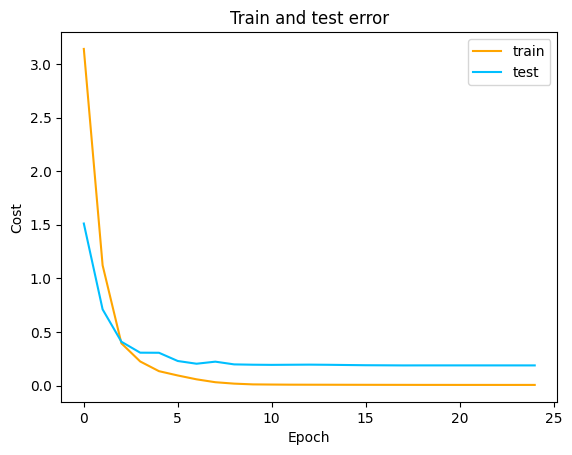

In [ ]:
plt.plot(cost_history[0], color='orange', label='train')
plt.plot(cost_history[1], color='deepskyblue', label='test')
plt.title('Train and test error')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Inference on training set
yhat_train = batched_predict_with_cleanup(train_X, train_y, params, dims)
print(f'Training accuracy: {accuracy_score(y_pred=yhat_train, y_true=np.argmax(train_y, axis=0)):.4f}')

# Inference on test set
yhat_test = batched_predict_with_cleanup(test_X, test_y, params, dims)
print(f'Test accuracy: {accuracy_score(y_pred=yhat_test, y_true=np.argmax(test_y, axis=0)):.4f}')

Training accuracy: 1.0000
Test accuracy: 0.9360
